# Predicting the number of mistakes in chess games based on the chosen opening, time control and ranking difference
   
Authors:
- Bartosz Więcek, 400421
- Dominik Czyżyk, 401858

## 1. Problem formulation.
#### a) Problem
The impact of the chess opening on the outcome of a game is a captivating subject that garners the attention of both professional players and enthusiasts of this noble game. Choosing the right opening can be crucial to the course of the entire game, affecting the number of errors made and, consequently, the chances of winning or even achieving an easy draw.

The chess opening refers to the initial moves made by each player on the board. There is an immense number of different openings, each with its unique characteristics and strategies. Some openings focus on rapid pawn development, while others emphasize control of central squares or the deployment of pieces. The choice of a specific opening may stem from a player's preferences but also from the analysis and knowledge of various variations.

The objective of this project is to examine the impact of a specific opening on the number of errors committed during a chess game. By analyzing the results of conducted matches, we will be able to assess whether there is a correlation between the chosen opening and subsequent mistakes. Do certain openings lead to a higher number of blunders, while others facilitate a more stable and controlled game?

Investigating such a relationship can contribute to the refinement of chess-playing strategies for both professional players and amateurs. Understanding which openings are riskier or safer can influence tactical choices during gameplay. Furthermore, analyzing the impact of the opening on the game's outcome can provide valuable insights for predicting errors and making appropriate decisions.

In the further stages of the project, we will delve into various chess openings and analyze game results, focusing on identifying patterns and trends. Through this study, we aim to answer the question of whether the choice of opening can indeed influence the course and outcome of a chess game.

#### b) Use Cases
This project aims to analyze the influence of different chess openings on the number of errors committed during a game. By studying the data and conducting statistical analyses, we can uncover patterns and trends regarding the impact of specific openings on gameplay accuracy. Such insights can have practical applications in several use cases, including:

- <b>Chess Training and Coaching</b>: Understanding the relationship between openings and errors can aid chess trainers and coaches in developing more effective training programs. By identifying openings that tend to lead to higher error rates, trainers can focus on addressing specific weaknesses in their students' gameplay and provide targeted guidance.

- <b>Game Strategy Development</b>: The analysis of opening choices and their impact on errors can assist chess players in refining their game strategies. Players can leverage this knowledge to select openings that align with their playing style and minimize the likelihood of making mistakes, thereby enhancing their overall performance.

- <b>Opening Repertoire Selection</b>: For both amateur and professional players, the choice of opening repertoire is a crucial decision. The analysis conducted in this project can provide valuable insights into the relative strengths and weaknesses of different openings, allowing players to construct a well-rounded repertoire tailored to their individual preferences and objectives.

- <b>Opponent Analysis</b>: Examining the relationship between openings and errors can also be useful for analyzing opponents' gameplay tendencies. By understanding the typical errors associated with certain openings, players can anticipate their opponents' moves and capitalize on potential weaknesses.

#### c) Data origin
The dataset used in the project comes from the Kaggle platform and is called "Lichess Chess Game Dataset". It can be found at the following link: https://www.kaggle.com/datasets/asrinyigit/lichess-chess-game-dataset or in a csv file: lichess_games_dataset.csv

This dataset was collected from the Lichess platform, which is a popular chess game website. It contains an extensive collection of recorded chess games that have been played on this platform.

The dataset contains a variety of information about the games played, such as the moves made by players, the time taken to make a move, the ranking of players, the result of the game and much more. The available data allows us to conduct detailed analyses on strategy, tactics, game results and other aspects related to the game of chess.


#### d) DAG
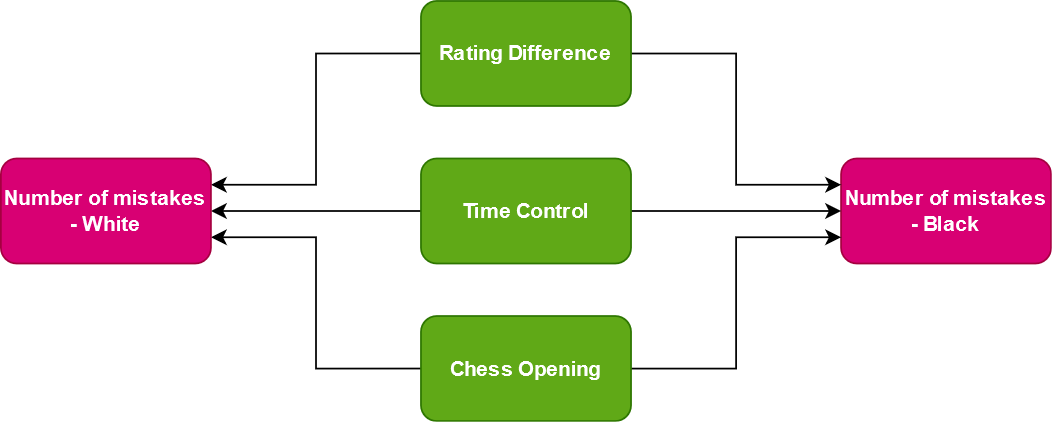

#### e) Confoundings
Confounding is a phenomenon in which the influence of one variable on the outcome variable is distorted by the presence of another variable, known as a confounding factor. In the considered model, there are two types of confounding:

- <b>Pipe</b>: "Time Conrol" can have an influence on the "Chess Opening", creating a relationship between these two factors. It is important to account for this relationship in the model to avoid potential confounding and to assess the associations between variables more accurately.

- <b>Collider</b>: The variables "Number of mistakes - White" and "Number of mistakes - Black" are colliders because they are directly dependent on different factors, such as "Time Conrol", "Chess Opening" and "Rating Difference." The presence of a collider can lead to erroneous conclusions about the relationship between mistakes made by white and black players.

## Program
Importing neccessary libraries.

In [1]:
from cmdstanpy import CmdStanModel
import seaborn as sns

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data preprocessing
### a) Data loading
There are two csv files needed:
- "lichess_games_dataset.csv" - file with chess games data
- "chess_openings.csv" - file with chess openings names used in ECO (opening code) to opening name decoding.

In [4]:
df_games = pd.read_csv('lichess_games_dataset.csv', usecols=["Time Control", "White Rating", "Black Rating", "Opening ECO", "White's Number of Mistakes", "White's Number of Blunders", 
                                                             "Black's Number of Mistakes", "Black's Number of Blunders", "Winner"])
df_openings = pd.read_csv('chess_openings.csv')

In [5]:
df_games.head()

,Time Control,White Rating,Black Rating,Opening ECO,White's Number of Mistakes,White's Number of Blunders,Black's Number of Mistakes,Black's Number of Blunders,Winner
0,10 + 0,1441,1559,C20,2,0,4,1,White
1,10 + 15,1258,1567,C46,0,1,0,0,Black
2,60 + 10,1697,1712,C68,0,0,0,2,White
3,10 + 0,1978,1868,D31,0,0,0,1,White
4,10 + 0,2073,1816,A01,2,0,3,0,White


In [6]:
df_openings.head()

,ECO,name,moves
0,A00,Anderssen's Opening,1.a3
1,A00,"Polish Gambit, Anderssen's Opening",1.a3 a5 2.b4
2,A00,Creepy Crawly Formation,1.a3 e5 2.h3 d5
3,A00,Andersspike,1.a3 g6 2.g4
4,A00,Ware; Meadow Hay; Crab,1.a4


### b) Openning ECO mapping to name
Mapping is done using chess_openings dataset ("chess_openings.csv").

In [7]:
def map_ECO_to_name(ECO):
    mapped_ECO = list(df_openings.loc[df_openings["ECO"] == ECO]["name"])[0]
    try:
        i = 1
        while mapped_ECO == ECO:
            mapped_ECO = list(df_openings.loc[df_openings["ECO"] == ECO]["name"])[i]
            i += 1
    except IndexError:
        return None
    if ";" in mapped_ECO:
        mapped_ECO = mapped_ECO.split(";")[0] if ECO not in mapped_ECO.split(";")[0] else mapped_ECO.split(";")[1]
    if "," in mapped_ECO:
        mapped_ECO = mapped_ECO.split(",")[0] if ECO not in mapped_ECO.split(",")[0] else mapped_ECO.split(",")[1]
    return mapped_ECO

ECOs = list(df_games["Opening ECO"])
ECOs_names = [map_ECO_to_name(ECO) for ECO in ECOs]
df_games.insert(4, "Oppening Name", ECOs_names)

### c) Selecting four openings and coding them.

In [8]:
number_of_records = {}

for n, record in df_games.iterrows():
    opening = record['Oppening Name']

    try:
        number_of_records[opening]
    except KeyError:
        number_of_records[opening] = 1
        continue
    number_of_records[opening] += 1

selected_openings  = {}

for op, num in number_of_records.items():
    if num <= 300:
        continue
    print(f'{op}:\t{num}')
    selected_openings[op] = num

King Pawn Game:	306
Italian Game:	555
Franco-Sicilian Defense:	637
Center Counter:	630
Queen Pawn Game:	678
Indian Defense:	381
Petroff Defense:	308
Ware Defense:	563
Caro-Kann Defense:	324
Philidor Defense:	496
Hartlaub Gambit:	511
Anderssen's Opening:	635
Sicilian Defense:	486
Zukertort Variation:	348


Chosen openings are <b>Petroff Defense</b>, <b>Sicilian Defense</b>, <b>Queen Pawn Game</b>, <b>Italian Game</b>. Those openings were chosen because of two main reasons:
- for each of them there is at least 300 records (it is enough number to get reasonable results),
- One of them (Petroff Defense) is considered debut of a more tranquil kind. We therefore expect these games to be characterized by fewer errors. Another one (Sicilian Defense), on the other hand, is considered aggressive debut, leading to more dynamic and therefore less accurate play. The last two openings (Queen Pawn Game, Italian Game) can (depending on the variant) lead to both calmer and more complicated play, and thus the number of errors can vary quite a bit. 

In [9]:
df_games = df_games.loc[(df_games["Oppening Name"] == 'Sicilian Defense') | (df_games["Oppening Name"] == 'Petroff Defense') |
                        (df_games["Oppening Name"] == 'Queen Pawn Game') | (df_games["Oppening Name"] == 'Italian Game')]

df_games.insert(loc=5, column="Opening Name Mapped", value='')

df_games["Opening Name Mapped"].mask(df_games["Oppening Name"] == 'Sicilian Defense', 1, inplace=True)
df_games["Opening Name Mapped"].mask(df_games["Oppening Name"] == 'Petroff Defense', 2, inplace=True)
df_games["Opening Name Mapped"].mask(df_games["Oppening Name"] == 'Queen Pawn Game', 3, inplace=True)
df_games["Opening Name Mapped"].mask(df_games["Oppening Name"] == 'Italian Game', 4, inplace=True)

Coding opening names to integers is needed needed for use them in the model.

### d) Merging mistakes with blunders
Blunders in chess are just "more serious mistakes". That's why they can be added to make the total number of mistakes (of all weights) done by players.

In [10]:
df_games['White\'s Number of Mistakes'] = df_games['White\'s Number of Mistakes'] + df_games['White\'s Number of Blunders']
df_games['Black\'s Number of Mistakes'] = df_games['Black\'s Number of Mistakes'] + df_games['Black\'s Number of Blunders']
df_games.drop(columns=['White\'s Number of Blunders', 'Black\'s Number of Blunders'], inplace=True)
df_games.head()

,Time Control,White Rating,Black Rating,Opening ECO,Oppening Name,Opening Name Mapped,White's Number of Mistakes,Black's Number of Mistakes,Winner
6,15 + 0,1500,2058,C50,Italian Game,4,2,4,White
26,3 + 0,1883,1899,C50,Italian Game,4,4,8,White
28,10 + 15,1595,1483,D00,Queen Pawn Game,3,2,1,Black
36,60 + 10,2005,1986,C42,Petroff Defense,2,0,4,White
37,5 + 5,2038,1996,D00,Queen Pawn Game,3,4,6,White


### e) Time Control mapping to name and coding
Mapping helps to create three main groups used in chess (Classic, Rapid and Blitz) from many time cotrol values.
Coding time control to integers is needed needed for use them in the model.

In [11]:
df_games["Time Control"].unique()

array(['15 + 0', '3 + 0', '10 + 15', '60 + 10', '5 + 5', '3 + 2',
       '30 + 25', '60 + 0', '10 + 0', '5 + 0', '30 + 0'], dtype=object)

In [14]:
df_games.insert(loc=1, column="Time Control Name", value='')
df_games["Time Control Name"].mask((df_games["Time Control"] == '3 + 2') | (df_games["Time Control"] == '5 + 5') | (df_games["Time Control"] == '5 + 0') | (df_games["Time Control"] == '3 + 0'), 'Blitz', inplace=True)
df_games["Time Control Name"].mask((df_games["Time Control"] == '10 + 0') | (df_games["Time Control"] == '10 + 15') | (df_games["Time Control"] == '15 + 0'), 'Rapid', inplace=True)
df_games["Time Control Name"].mask((df_games["Time Control"] == '60 + 10') | (df_games["Time Control"] == '60 + 0') | (df_games["Time Control"] == '30 + 0') | (df_games["Time Control"] == '30 + 25'), 'Classic', inplace=True)

df_games.insert(loc=2, column="Time Control Mapped", value='')
df_games["Time Control Mapped"].mask((df_games["Time Control Name"] == 'Blitz'), 1, inplace=True)
df_games["Time Control Mapped"].mask((df_games["Time Control Name"] == 'Rapid'), 2, inplace=True)
df_games["Time Control Mapped"].mask((df_games["Time Control Name"] == 'Classic'), 3, inplace=True)

### f) Calculating rating difference

In [15]:
df_games.insert(loc=3, column="Rating Difference", value='')
df_games['Rating Difference'] = df_games['White Rating'] - df_games['Black Rating']
df_games.drop(columns=['White Rating', 'Black Rating'], inplace=True)
df_games.head()

,Time Control,Time Control Name,Time Control Mapped,Rating Difference,Opening ECO,Oppening Name,Opening Name Mapped,White's Number of Mistakes,Black's Number of Mistakes,Winner
6,15 + 0,Rapid,2,-558,C50,Italian Game,4,2,4,White
26,3 + 0,Blitz,1,-16,C50,Italian Game,4,4,8,White
28,10 + 15,Rapid,2,112,D00,Queen Pawn Game,3,2,1,Black
36,60 + 10,Classic,3,19,C42,Petroff Defense,2,0,4,White
37,5 + 5,Blitz,1,42,D00,Queen Pawn Game,3,4,6,White


### g) Removing rows with NaN values

In [16]:
df_games.dropna()

,Time Control,Time Control Name,Time Control Mapped,Rating Difference,Opening ECO,Oppening Name,Opening Name Mapped,White's Number of Mistakes,Black's Number of Mistakes,Winner
6,15 + 0,Rapid,2,-558,C50,Italian Game,4,2,4,White
26,3 + 0,Blitz,1,-16,C50,Italian Game,4,4,8,White
28,10 + 15,Rapid,2,112,D00,Queen Pawn Game,3,2,1,Black
36,60 + 10,Classic,3,19,C42,Petroff Defense,2,0,4,White
37,5 + 5,Blitz,1,42,D00,Queen Pawn Game,3,4,6,White
...,...,...,...,...,...,...,...,...,...,...
18374,5 + 0,Blitz,1,-125,B20,Sicilian Defense,1,4,6,White
18380,10 + 0,Rapid,2,24,C50,Italian Game,4,2,3,White
18404,5 + 5,Blitz,1,13,C42,Petroff Defense,2,3,3,Black
18424,15 + 0,Rapid,2,-4,D00,Queen Pawn Game,3,2,4,White


### h) Saving data to csv

In [17]:
df_games.to_csv('Chess_data_after_preprocessing.csv')

## 3. Model
### a) Models specification
- <b>Model 1</b> - it takes into account time control and ranking difference. This model is designed to analyze the effect of time control and ranking difference on the number of errors of each party. The model takes into account two independent variables: "time_control" (representing the type of time controlled) and "rating_difference" (representing the ranking difference between players). By appropriately assigning coefficients (e.g. gamma_white), the model estimates the effect of these variables on the number of player errors. Analysis of this model will allow us to assess how time control and ranking difference affect the quality of the game.
- <b>Model 2</b> - This model extends the "Model 1" by also considering the "opening" variable, which represents the choice of opening in the game. We assume that "opening" can affect game performance, regardless of time control and ranking difference. In the model, we include factors such as "time_control," "rating_difference" and "opening" that affect the outcome variable "mistakes." By estimating the relevant coefficients, the model will allow us to assess the impact of these variables on the number of player mistakes.

### b) Difference between models
In "Model 1", we analyze the effect of time control and ranking difference on game performance. We assume that the number of player errors depends only on these two variables. In "Model 2", we extend the analysis by additionally considering the "opening" variable, which represents the choice of opening in the game. Both models allow us to evaluate the impact of these variables on game performance, but the second model additionally includes the choice of opening as a factor affecting player errors.

### c) Models difference justification
Such different models will be the best for studying the effect of chess opening on the number of errors made by players (which is the goal of this project), since the only difference between them is precisely the fact of taking into account or not taking into account the chosen debit.

### d) Models description

Common elements of the models (formulas and parameters that fulfill the same roles, differing at most in values between models):
- Inputs include information about the number of samples (N), the difference in ranking (rating_difference), time control (time_control), and the number of mistakes of the white player (mistakes_white_model) and the black player (mistakes_black_model).
- Model parameters include "gamma_white" and "gamma_black" (influence of ranking) and "time_controll_coeff_blitz", "time_controll_coeff_rapid" and "time_controll_coeff_classic" (influence of type of time controlled).

Elements included in "Model 2" only:
- The variables "opening_coeff_sicilian", "opening_coeff_petroff", "opening_coeff_queen_pawn" and "opening_coeff_italian" (influence of opening choice) were added to the model parameters.


In the model section, calculations are made for the number of player errors based on the parameters and input data. The poisson_log function is used, which operates on the logarithms of the expected number of events to account for the positivity condition of the lambda parameter in the Poisson distribution. The logarithmic transformation allows modeling the value of λ in terms of the whole real number, which is important because of the positivity requirement for λ in a Poisson distribution. The poisson_log function generates a Poisson distribution based on the logarithm of the expected number of events, and the poisson_log_rng function generates random values from this distribution. Using the poisson_log function allows you to take into account the fact that the lambda parameter must be add.

$$\log \lambda_{color}=\gamma_{color}\ *\ rating\_difference\ +\ time\_controll\_coeff\ +\ (\underbrace{oppening\_coeff}_{For\ Model\ 2\  only})$$

$$ mistakes_{color}\sim\mathrm{Poisson}(\lambda_{color})$$

## 4. Priors
Data loading

In [92]:
df = pd.read_csv('Chess_data_after_preprocessing.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,Time Control,Time Control Name,Time Control Mapped,Rating Difference,Opening ECO,Oppening Name,Opening Name Mapped,White's Number of Mistakes,Black's Number of Mistakes,Winner
0,15 + 0,Rapid,2,-558,C50,Italian Game,4,2,4,White
1,3 + 0,Blitz,1,-16,C50,Italian Game,4,4,8,White
2,10 + 15,Rapid,2,112,D00,Queen Pawn Game,3,2,1,Black
3,60 + 10,Classic,3,19,C42,Petroff Defense,2,0,4,White
4,5 + 5,Blitz,1,42,D00,Queen Pawn Game,3,4,6,White
...,...,...,...,...,...,...,...,...,...,...
2022,5 + 0,Blitz,1,-125,B20,Sicilian Defense,1,4,6,White
2023,10 + 0,Rapid,2,24,C50,Italian Game,4,2,3,White
2024,5 + 5,Blitz,1,13,C42,Petroff Defense,2,3,3,Black
2025,15 + 0,Rapid,2,-4,D00,Queen Pawn Game,3,2,4,White


Setting values for constants

In [93]:
N = df.shape[0]
time_control_list = list(df['Time Control Mapped'])
opening_list = list(df['Opening Name Mapped'])
rating_difference_list = list(df['Rating Difference'])
mistakes_white_list = list(df['White\'s Number of Mistakes'])
mistakes_black_list = list(df['Black\'s Number of Mistakes'])

R = 100

### Model 1 - prior

#### a) Prior parameters values with explanation:
- <b>gamma\_white = normal\_rng(-0.0015, 0.0001)</b> - gamma\_white is a coefficient that determines the effect of the ranking difference (rating\_difference) on the number of mistakes made by a player playing with the white color (mistakes\_white). The value of μ is negative, because a positive rating difference means an advantage for the white color (we assume that less mistakes are made when playing with a weaker player).
- <b>gamma\_black = normal\_rng(0.0015, 0.0001)</b> - gamma\_black is a coefficient that determines the effect of the ranking difference (rating\_difference) on the number of mistakes made by a player playing with the white black (mistakes\_black). The value of μ is positive, because a positive rating difference means an advantage for the white color (we assume that more mistakes are made when playing with a stronger player).
- <b>time\_controll\_coeff</b> - time\_controll\_coeff is a vector of coefficients that determine the effect of the time controll (time\_controll) on the number of mistakes made by both players (mistakes\_white & mistakes\_black). The assumption is that the faster game is the more mistakes are done.
  - <b>time\_controll\_coeff[1] = normal\_rng(1.3, 0.1)</b> - coefficient for blitz games (μ is the greatest among time\_controll\_coefficients)
  - <b>time\_controll\_coeff[2] = normal\_rng(0.8, 0.1)</b> - coefficient for rapid games (μ is greater than for classics but lower than for blitz)
  - <b>time\_controll\_coeff[3] = normal\_rng(0.4, 0.1)</b> - coefficient for classic games (μ is the lowest among time\_controll\_coefficients)


In [94]:
model_1_ppc = CmdStanModel(stan_file='stan_files/model_1_ppc.stan')

model_1_prior = model_1_ppc.sample(
    data={
        'rating_difference': rating_difference_list,
        'N': len(time_control_list),
        'time_control': time_control_list,
        },
    seed=19042023,
    fixed_param=True,
    iter_sampling=R, 
    iter_warmup=0,
    chains=1
)

model_1_prior_df = model_1_prior.draws_pd()
model_1_prior_df.head()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                    


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,gamma_white,gamma_black,time_controll_coeff[1],time_controll_coeff[2],time_controll_coeff[3],mistakes_white[1],mistakes_white[2],mistakes_white[3],...,mistakes_black[2018],mistakes_black[2019],mistakes_black[2020],mistakes_black[2021],mistakes_black[2022],mistakes_black[2023],mistakes_black[2024],mistakes_black[2025],mistakes_black[2026],mistakes_black[2027]
0,0.0,0.0,-0.001521,0.001432,1.17601,0.811876,0.472156,5.0,1.0,0.0,...,3.0,1.0,2.0,2.0,2.0,1.0,3.0,3.0,3.0,3.0
1,0.0,0.0,-0.001620,0.001312,1.33492,0.662482,0.349655,5.0,3.0,1.0,...,1.0,0.0,3.0,5.0,3.0,5.0,3.0,8.0,1.0,0.0
2,0.0,0.0,-0.001435,0.001665,1.37245,0.737271,0.286275,5.0,5.0,3.0,...,3.0,4.0,5.0,4.0,4.0,3.0,3.0,1.0,0.0,0.0
3,0.0,0.0,-0.001355,0.001473,1.11763,0.726541,0.287589,3.0,1.0,1.0,...,1.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,1.0,2.0
4,0.0,0.0,-0.001683,0.001416,1.40823,0.743485,0.290130,4.0,4.0,1.0,...,1.0,2.0,5.0,2.0,3.0,7.0,4.0,6.0,2.0,1.0


#### b) Prior predictive checks for parameters

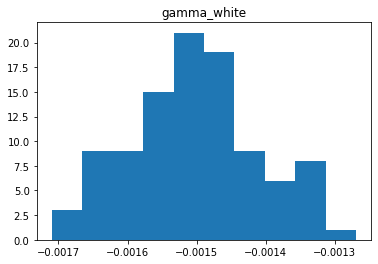

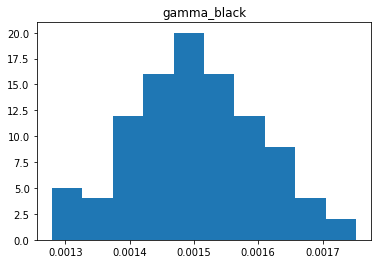

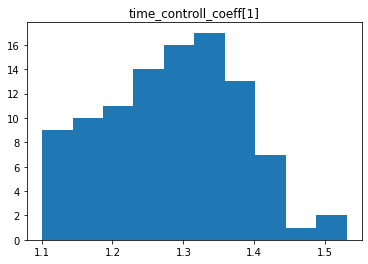

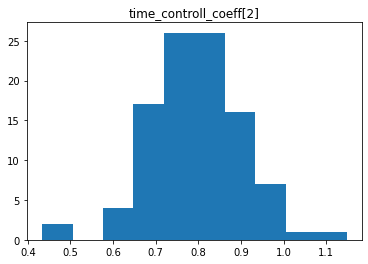

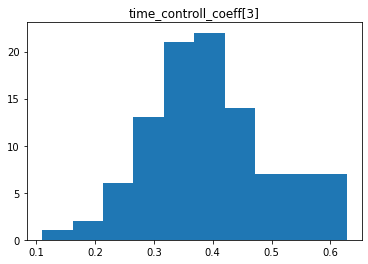

In [95]:
for parameter in ['gamma_white', 'gamma_black', 'time_controll_coeff[1]', 'time_controll_coeff[2]', 'time_controll_coeff[3]']:
    plt.hist(model_1_prior_df[parameter])
    plt.title(parameter)
    plt.show()

Parameters simulated from priors meet our expectations.

#### c) Prior predictive checks for measurements

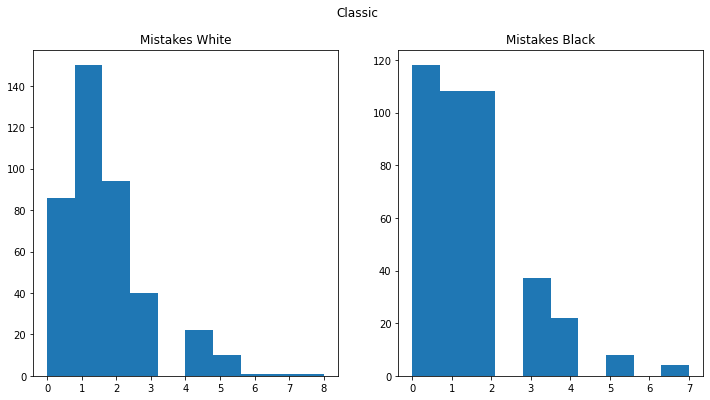

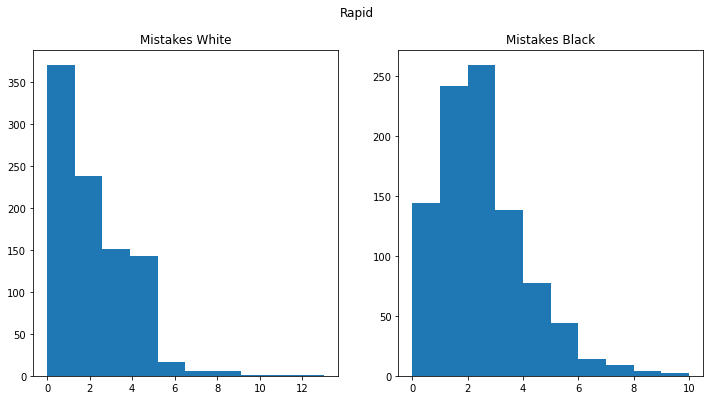

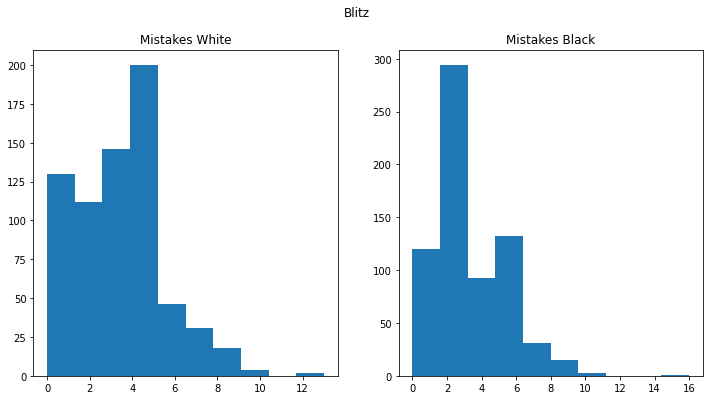

In [96]:
mistakes_by_time_control = {
    'Classic': {'Black': [], 'White': []},
    'Rapid': {'Black': [], 'White': []},
    'Blitz': {'Black': [], 'White': []}
}

time_control_mapping = {
    3: 'Classic',
    2: 'Rapid',
    1: 'Blitz'
} 

for i in range(N):
    tc = time_control_mapping[time_control_list[i]]
    for color in ['Black', 'White']:
        mistakes_by_time_control[tc][color].append(model_1_prior_df[f'mistakes_{color.lower()}[{i+1}]'].values[59])

for tc in mistakes_by_time_control.keys():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(tc)
    for c_i, color in enumerate(['White', 'Black']):
        axs[c_i].hist(mistakes_by_time_control[tc][color])
        axs[c_i].set_title(f'Mistakes {color}')
    
    plt.show()

Measurements simulated from priors meet our expectations - as the time available for moves decreases, the number of errors increases

#### d) Prior parameters selection.
As prior parameters were selected those values for which the model results were most similar to the actual data

In [98]:
best_matching = -1
best_matching_ind = -1

for row_index, row in model_1_prior_df.iterrows():
    tmp_mistakes_white = []
    tmp_mistakes_black = []

    for i in range(N):
        tmp_mistakes_white.append(row[f'mistakes_white[{i+1}]'])
        tmp_mistakes_black.append(row[f'mistakes_black[{i+1}]'])

    number_of_matched_white = sum(1 for x, y in zip(tmp_mistakes_white, mistakes_white_list) if x == y)
    number_of_matched_black = sum(1 for x, y in zip(tmp_mistakes_black, mistakes_black_list) if x == y)
    acceptance_percent = (number_of_matched_white + number_of_matched_black) / (len(mistakes_white_list) + len(mistakes_black_list)) * 100

    if acceptance_percent > best_matching:
        best_matching = acceptance_percent
        best_matching_ind = row_index

chosen_row_in_prior_model_1 = best_matching_ind
prior_parameters_model_1 = {}

print('Prior parameters for Model 1:')
for col_name in ['gamma_white', 'gamma_black', 'time_controll_coeff[1]', 'time_controll_coeff[2]', 'time_controll_coeff[3]']:
    prior_parameters_model_1[col_name] = model_1_prior_df.loc[chosen_row_in_prior_model_1, col_name]
    print(f"\t{col_name} = {model_1_prior_df.loc[chosen_row_in_prior_model_1, col_name]}")

Prior parameters for Model 1:
	gamma_white = -0.00144638
	gamma_black = 0.00137461
	time_controll_coeff[1] = 1.23487
	time_controll_coeff[2] = 0.836987
	time_controll_coeff[3] = 0.295052


### Model 2 - prior

#### a) Prior parameters values with explanation:
- <b>gamma\_white = normal\_rng(-0.0015, 0.0001)</b> - gamma\_white is a coefficient that determines the effect of the ranking difference (rating\_difference) on the number of mistakes made by a player playing with the white color (mistakes\_white). The value of μ is negative, because a positive rating difference means an advantage for the white color (we assume that less mistakes are made when playing with a weaker player).
- <b>gamma\_black = normal\_rng(0.0015, 0.0001)</b> - gamma\_black is a coefficient that determines the effect of the ranking difference (rating\_difference) on the number of mistakes made by a player playing with the white black (mistakes\_black). The value of μ is positive, because a positive rating difference means an advantage for the white color (we assume that more mistakes are made when playing with a stronger player).
- <b>time\_controll\_coeff</b> - time\_controll\_coeff is a vector of coefficients that determine the effect of the time controll (time\_controll) on the number of mistakes made by both players (mistakes\_white & mistakes\_black). The assumption is that the faster game is the more mistakes are done.
  - <b>time\_controll\_coeff[1] = normal\_rng(1.3, 0.1)</b> - coefficient for blitz games (μ is the greatest among time\_controll\_coefficients)
  - <b>time\_controll\_coeff[2] = normal\_rng(0.8, 0.1)</b> - coefficient for rapid games (μ is greater than for classics but lower than for blitz)
  - <b>time\_controll\_coeff[3] = normal\_rng(0.4, 0.1)</b> - coefficient for classic games (μ is the lowest among time\_controll\_coefficients)
- <b>opening\_coeff</b> - opening\_coeff is a vector of coefficients that determine the effect of the choosen opening on the number of mistakes made by both players (mistakes\_white & mistakes\_black). In a more aggressive opening, more mistakes will be made, while in a calm, tie-biased opening number of mistakes will be fewer.
  - <b>opening\_coeff[1] = normal\_rng(0.6, 0.05)</b> - coefficient for Sicilian opening (μ is the greatest among opening\_coefficients)
  - <b>opening\_coeff[2] = normal\_rng(0.25, 0.05)</b> - coefficient for Petroff Defense opening (μ is the lowest among opening\_coefficients)
  - <b>opening\_coeff[3] = normal\_rng(0.35, 0.05)</b> - coefficient for Queen Pawn opening (μ is greater than for Petroff Defense but lower than for Sicilian)
  - <b>opening\_coeff[4] = normal\_rng(0.35, 0.05)</b> - coefficient for Italian opening (μ is greater than for Petroff Defense but lower than for Sicilian)

In [99]:
model_2_ppc = CmdStanModel(stan_file='stan_files/model_2_ppc.stan')

model_2_prior = model_2_ppc.sample(
    data={
        'rating_difference': rating_difference_list,
        'N': len(time_control_list),
        'time_control': time_control_list,
        'opening': opening_list
        },
    seed=19042023,
    fixed_param=True,
    iter_sampling=R, 
    iter_warmup=0,
    chains=1
)

model_2_prior_df = model_2_prior.draws_pd()
model_2_prior_df.head()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                    


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,gamma_white,gamma_black,time_controll_coeff[1],time_controll_coeff[2],time_controll_coeff[3],opening_coeff[1],opening_coeff[2],opening_coeff[3],...,mistakes_black[2018],mistakes_black[2019],mistakes_black[2020],mistakes_black[2021],mistakes_black[2022],mistakes_black[2023],mistakes_black[2024],mistakes_black[2025],mistakes_black[2026],mistakes_black[2027]
0,0.0,0.0,-0.001521,0.001432,1.17601,0.811876,0.472156,0.630683,0.305196,0.272360,...,9.0,2.0,15.0,6.0,3.0,3.0,5.0,5.0,4.0,4.0
1,0.0,0.0,-0.001424,0.001625,1.17026,0.821946,0.465057,0.648372,0.320042,0.354479,...,5.0,3.0,6.0,2.0,7.0,4.0,3.0,2.0,4.0,4.0
2,0.0,0.0,-0.001515,0.001430,1.22963,0.726746,0.449813,0.662715,0.260256,0.326709,...,2.0,5.0,7.0,4.0,7.0,6.0,5.0,4.0,6.0,2.0
3,0.0,0.0,-0.001307,0.001676,1.24910,0.803572,0.090108,0.592138,0.322077,0.397858,...,2.0,3.0,6.0,11.0,2.0,10.0,1.0,7.0,6.0,3.0
4,0.0,0.0,-0.001488,0.001531,1.14947,0.830487,0.169930,0.680737,0.239092,0.391354,...,7.0,3.0,16.0,4.0,5.0,5.0,3.0,3.0,3.0,3.0


#### b) Prior predictive checks for parameters

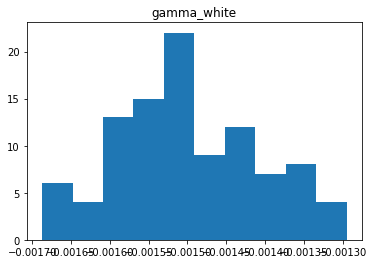

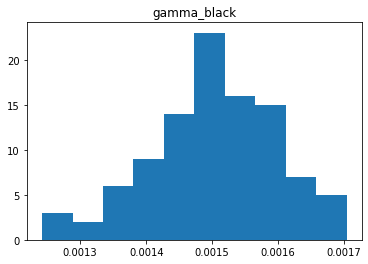

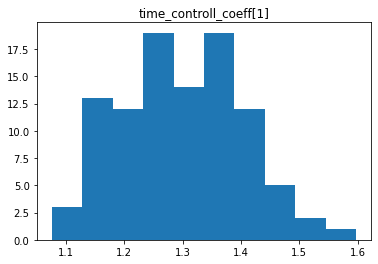

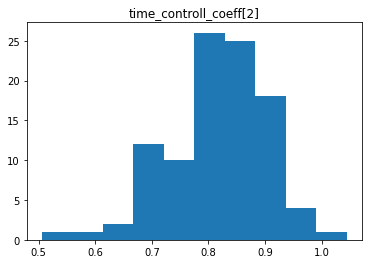

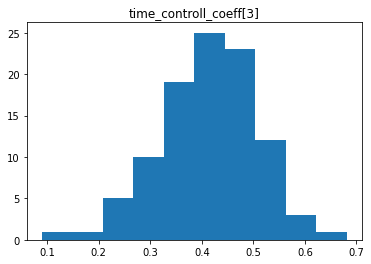

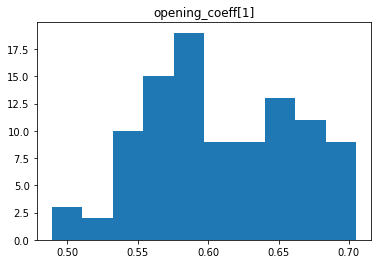

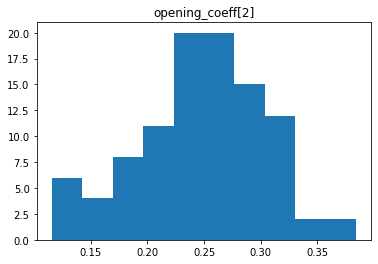

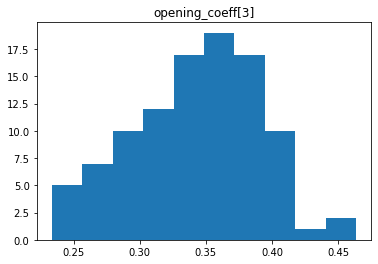

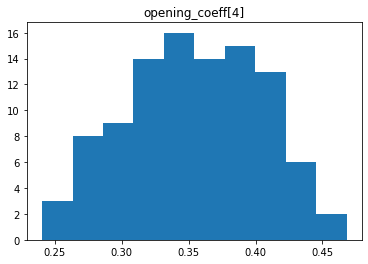

In [100]:
for parameter in ['gamma_white', 'gamma_black', 'time_controll_coeff[1]', 'time_controll_coeff[2]', 'time_controll_coeff[3]', 'opening_coeff[1]', 'opening_coeff[2]', 'opening_coeff[3]', 'opening_coeff[4]']:
    plt.hist(model_2_prior_df[parameter].loc[model_2_prior_df[parameter] != 0])
    plt.title(parameter)
    plt.show()

Parameters simulated from priors meet our expectations.

#### c) Prior predictive checks for measurements

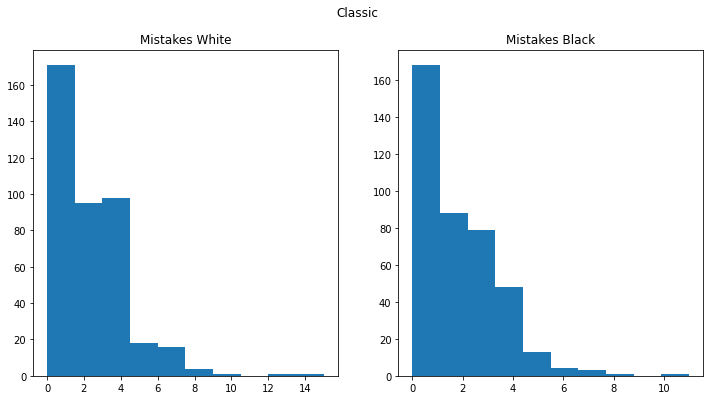

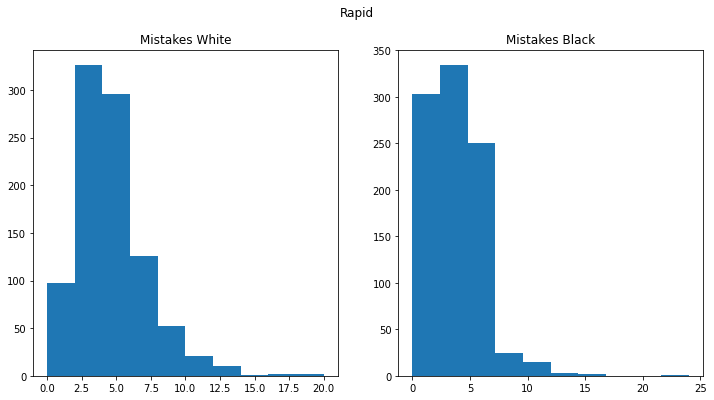

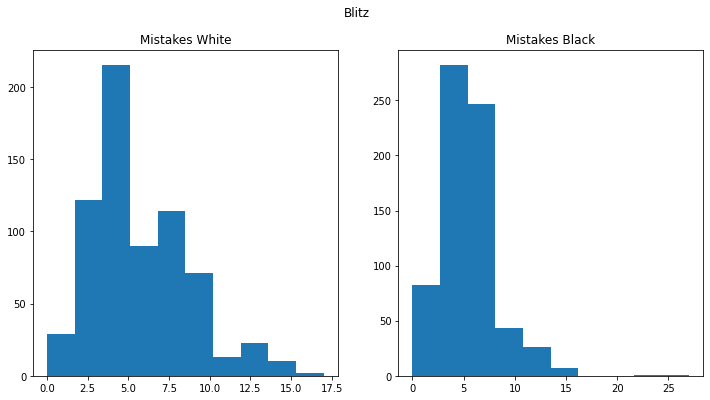

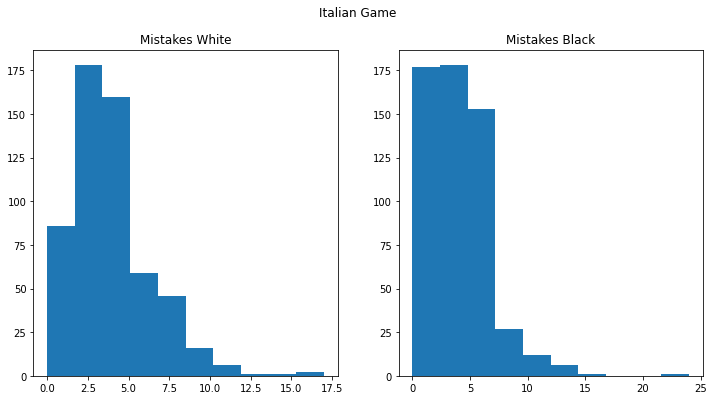

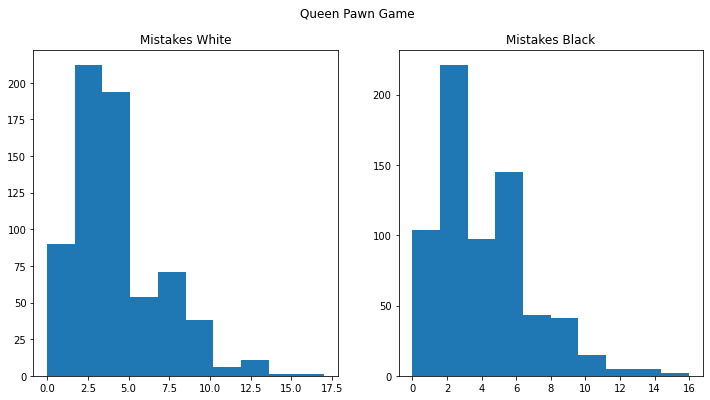

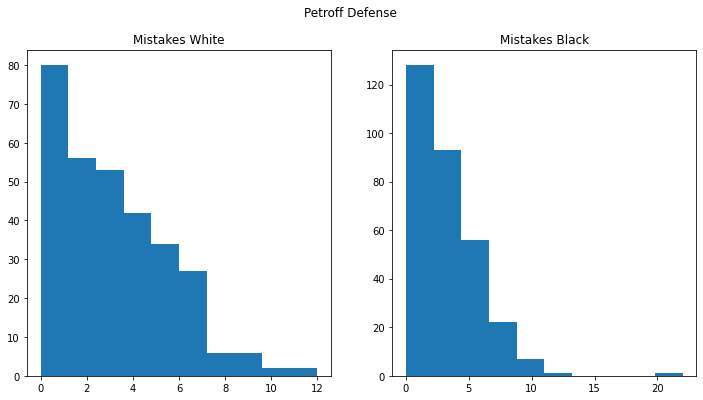

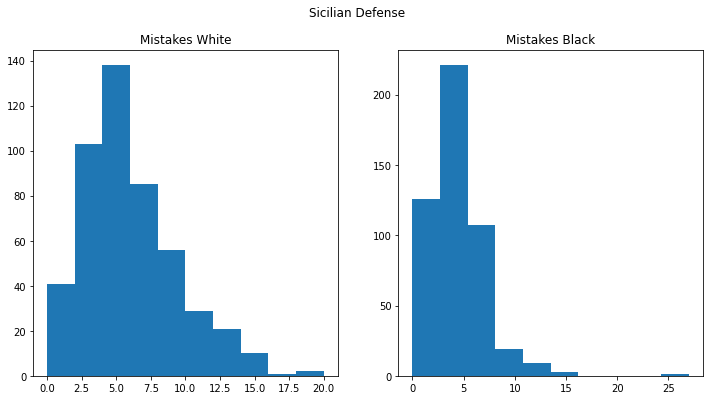

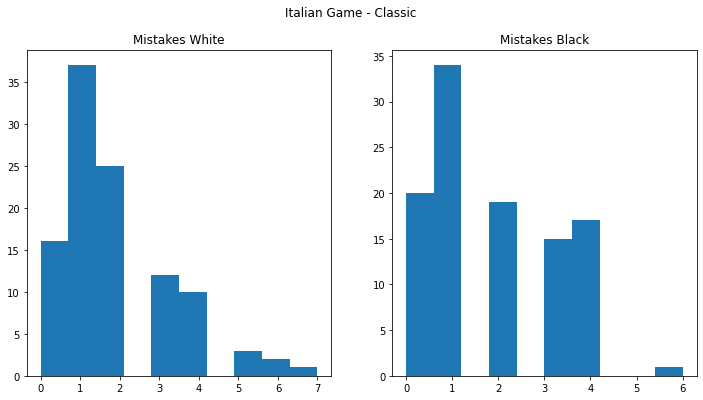

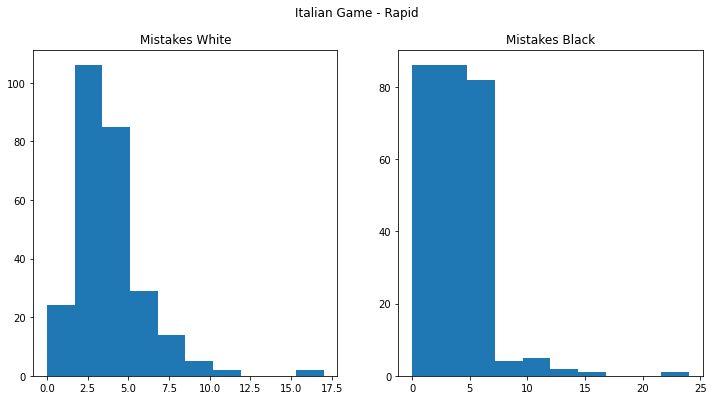

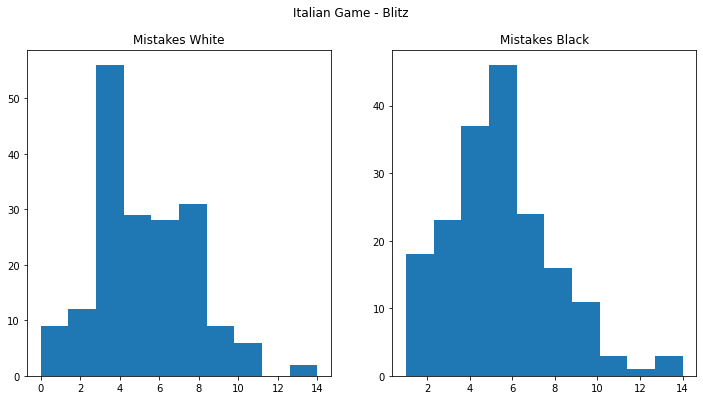

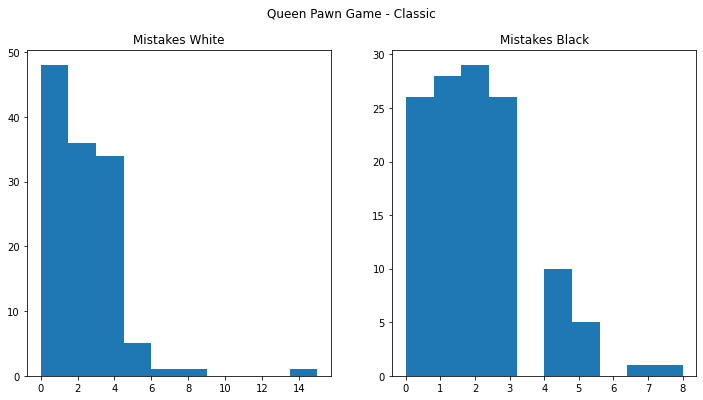

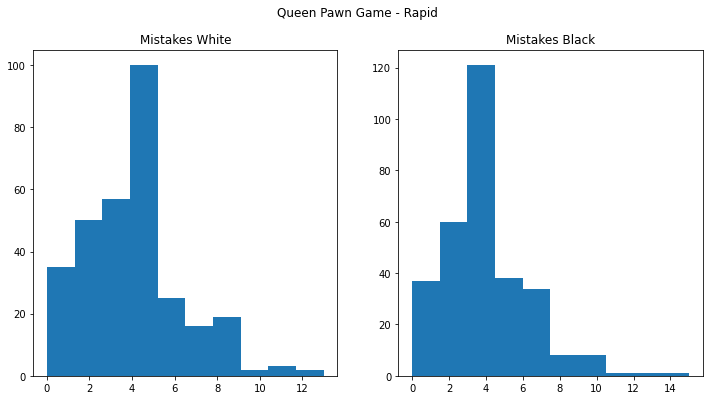

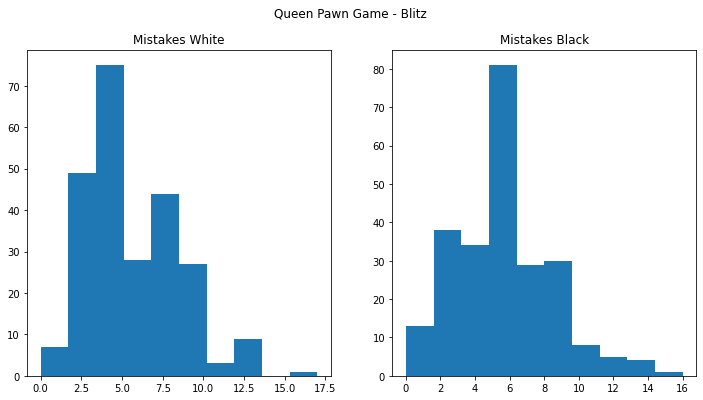

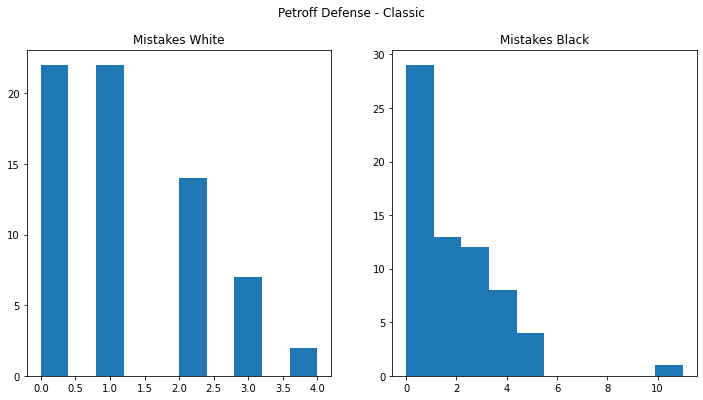

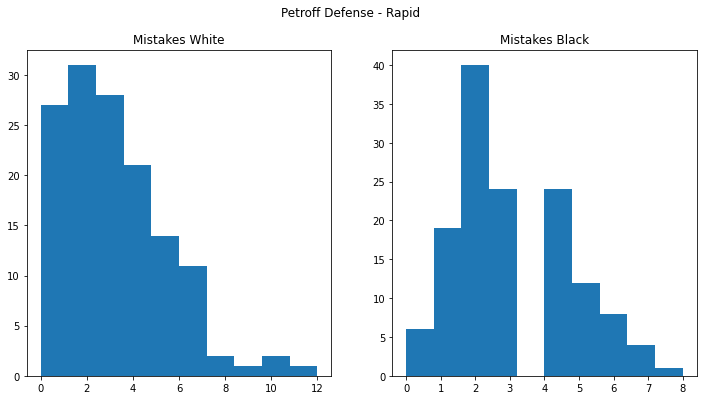

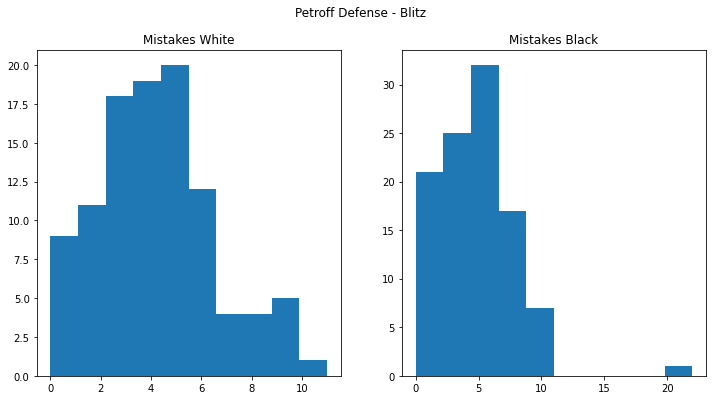

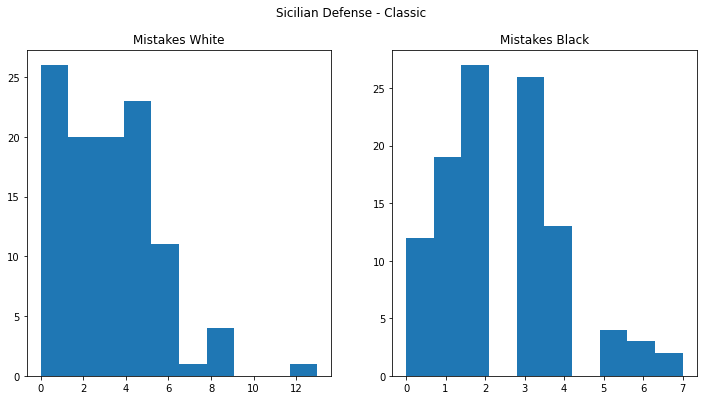

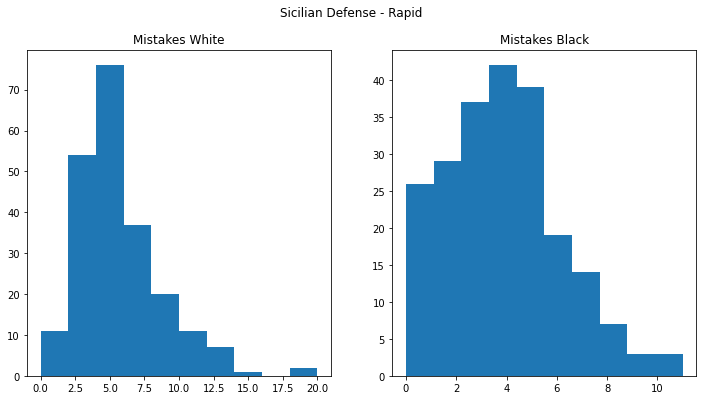

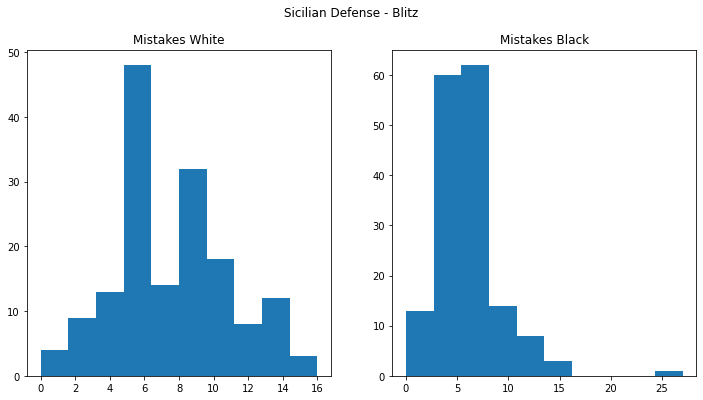

In [101]:
mistakes_by_time_control = {
    'Classic': {'Black': [], 'White': []},
    'Rapid': {'Black': [], 'White': []},
    'Blitz': {'Black': [], 'White': []}
}

mistakes_by_opening = {
    'Italian Game': {'Black': [], 'White': []},
    'Queen Pawn Game': {'Black': [], 'White': []},
    'Petroff Defense': {'Black': [], 'White': []},
    'Sicilian Defense': {'Black': [], 'White': []}
}

mistakes_by_tc_and_opening = {
    'Italian Game': deepcopy(mistakes_by_time_control),
    'Queen Pawn Game': deepcopy(mistakes_by_time_control),
    'Petroff Defense': deepcopy(mistakes_by_time_control),
    'Sicilian Defense': deepcopy(mistakes_by_time_control)
}

time_control_mapping = {
    3: 'Classic',
    2: 'Rapid',
    1: 'Blitz'
} 

opening_mapping = {
    4: 'Italian Game',
    3: 'Queen Pawn Game',
    2: 'Petroff Defense',
    1: 'Sicilian Defense'
} 

for i in range(N):
    tc = time_control_mapping[time_control_list[i]]
    op = opening_mapping[opening_list[i]]

    for color in ['Black', 'White']:
        mistakes_by_time_control[tc][color].append(model_2_prior_df[f'mistakes_{color.lower()}[{i+1}]'].values[19])
        mistakes_by_opening[op][color].append(model_2_prior_df[f'mistakes_{color.lower()}[{i+1}]'].values[19])
        mistakes_by_tc_and_opening[op][tc][color].append(model_2_prior_df[f'mistakes_{color.lower()}[{i+1}]'].values[19])

for tc in mistakes_by_time_control.keys():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(tc)
    for c_i, color in enumerate(['White', 'Black']):
        axs[c_i].hist(mistakes_by_time_control[tc][color])
        axs[c_i].set_title(f'Mistakes {color}')
    
    plt.show()

for op in mistakes_by_opening.keys():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(op)
    for c_i, color in enumerate(['White', 'Black']):
        axs[c_i].hist(mistakes_by_opening[op][color])
        axs[c_i].set_title(f'Mistakes {color}')
    
    plt.show()

for op in mistakes_by_opening.keys():
    for tc in mistakes_by_time_control.keys():
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f'{op} - {tc}')
        for c_i, color in enumerate(['White', 'Black']):
            axs[c_i].hist(mistakes_by_tc_and_opening[op][tc][color])
            axs[c_i].set_title(f'Mistakes {color}')
        
        plt.show()

Measurements simulated from priors meet our expectations, because:
- as the time available for moves decreases, the number of errors increases,
- openings consiedered as more agressive lead to higher number of mistakes.

#### d) Prior parameters selection.
As prior parameters were selected those values for which the model results were most similar to the actual data

In [102]:
best_matching = -1
best_matching_ind = -1

for row_index, row in model_2_prior_df.iterrows():
    tmp_mistakes_white = []
    tmp_mistakes_black = []

    for i in range(N):
        tmp_mistakes_white.append(row[f'mistakes_white[{i+1}]'])
        tmp_mistakes_black.append(row[f'mistakes_black[{i+1}]'])

    number_of_matched_white = sum(1 for x, y in zip(tmp_mistakes_white, mistakes_white_list) if x == y)
    number_of_matched_black = sum(1 for x, y in zip(tmp_mistakes_black, mistakes_black_list) if x == y)
    acceptance_percent = ((number_of_matched_white + number_of_matched_black) / (len(mistakes_white_list) + len(mistakes_black_list))) * 100

    if acceptance_percent > best_matching:
        best_matching = acceptance_percent
        best_matching_ind = row_index

chosen_row_in_prior_model_2 = best_matching_ind
prior_parameters_model_2 = {}

print('Prior parameters for Model 2:')
for col_name in ['gamma_white', 'gamma_black', 'time_controll_coeff[1]', 'time_controll_coeff[2]', 'time_controll_coeff[3]', 
                 'opening_coeff[1]', 'opening_coeff[2]', 'opening_coeff[3]', 'opening_coeff[4]']:
    prior_parameters_model_2[col_name] = model_2_prior_df.loc[chosen_row_in_prior_model_2, col_name]
    print(f"\t{col_name} = {model_2_prior_df.loc[chosen_row_in_prior_model_2, col_name]}")

Prior parameters for Model 2:
	gamma_white = -0.00141787
	gamma_black = 0.00154708
	time_controll_coeff[1] = 1.28198
	time_controll_coeff[2] = 0.840261
	time_controll_coeff[3] = 0.269627
	opening_coeff[1] = 0.675352
	opening_coeff[2] = 0.305338
	opening_coeff[3] = 0.389296
	opening_coeff[4] = 0.288916


## 5. Posterior analysis (Model 1)

Parameters chosen in prior

In [103]:
prior_parameters_model_1

{'gamma_white': -0.00144638,
 'gamma_black': 0.00137461,
 'time_controll_coeff[1]': 1.23487,
 'time_controll_coeff[2]': 0.836987,
 'time_controll_coeff[3]': 0.295052}

#### a) Model trainning and sampling

In [137]:
mistakes_white_model = deepcopy(mistakes_white_list)
mistakes_black_model = deepcopy(mistakes_black_list)

model_1_posterior = CmdStanModel(stan_file='stan_files/model_1_fit.stan')

model_1_fit = model_1_posterior.sample(
    data={
        'rating_difference': rating_difference_list,
        'N': len(time_control_list),
        'time_control': time_control_list,
        'mistakes_white_model': mistakes_white_model,
        'mistakes_black_model': mistakes_black_model
        }
)

INFO:cmdstanpy:compiling stan file /home/projekt/stan_files/model_1_fit.stan to exe file /home/projekt/stan_files/model_1_fit
INFO:cmdstanpy:compiled model executable: /home/projekt/stan_files/model_1_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/projekt/stan_files/model_1_fit.hpp /home/projekt/stan_files/model_1_fit.stan
Warning in '/home/projekt/stan_files/model_1_fit.stan', line 2, column 12: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/home/projekt/stan_files/model_1_fit.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/projekt/stan_files/model_1_fit.stan', lin


INFO:cmdstanpy:CmdStan done processing.


There were no issues with the sampling.

#### b) Analysis of samples obtained from the predictive distribution.
Model summary:

In [105]:
summary = model_1_fit.summary()
summary.head(6)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,4600.0000,4.700000e-02,1.800000,4600.0000,4600.0000,4600.0000,1400.0,24.0,1.0
gamma_white,-0.0014,9.300000e-08,0.000006,-0.0014,-0.0014,-0.0014,4500.0,74.0,1.0
gamma_black,0.0014,8.900000e-08,0.000006,0.0014,0.0014,0.0014,4700.0,77.0,1.0
time_controll_coeff_blitz,1.1000,3.100000e-06,0.000220,1.1000,1.1000,1.1000,4900.0,81.0,1.0
time_controll_coeff_rapid,0.7800,2.400000e-05,0.001700,0.7700,0.7800,0.7800,4800.0,79.0,1.0
time_controll_coeff_classic,0.2100,7.600000e-05,0.005200,0.2000,0.2100,0.2200,4700.0,77.0,1.0


Parameters values are similiar to those from priors but not the same.

In [106]:
model_1_fit_df = model_1_fit.draws_pd()
model_1_fit_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,gamma_white,gamma_black,time_controll_coeff_blitz,...,mistakes_black_pred[2018],mistakes_black_pred[2019],mistakes_black_pred[2020],mistakes_black_pred[2021],mistakes_black_pred[2022],mistakes_black_pred[2023],mistakes_black_pred[2024],mistakes_black_pred[2025],mistakes_black_pred[2026],mistakes_black_pred[2027]
0,4569.74,0.814108,0.458273,3.0,7.0,0.0,-4566.99,-0.001413,0.001402,1.13997,...,3.0,2.0,2.0,1.0,1.0,3.0,2.0,3.0,4.0,3.0
1,4571.23,0.996769,0.458273,3.0,7.0,0.0,-4569.26,-0.001402,0.001405,1.13966,...,3.0,1.0,1.0,6.0,1.0,1.0,2.0,4.0,4.0,1.0
2,4570.93,0.896218,0.458273,3.0,7.0,0.0,-4569.24,-0.001406,0.001405,1.13997,...,3.0,1.0,2.0,3.0,4.0,1.0,1.0,4.0,3.0,2.0
3,4571.74,0.985942,0.458273,3.0,7.0,0.0,-4570.28,-0.001407,0.001405,1.13958,...,0.0,3.0,2.0,2.0,5.0,3.0,3.0,2.0,1.0,4.0
4,4568.84,0.771899,0.458273,3.0,7.0,0.0,-4567.99,-0.001406,0.001407,1.13996,...,2.0,1.0,5.0,1.0,3.0,5.0,5.0,4.0,3.0,2.0


Choosing sample with best matching to reality.

In [107]:
best_matching = -1
best_matching_ind = -1

for row_index, row in model_1_fit_df.iterrows():
    tmp_mistakes_white = []
    tmp_mistakes_black = []

    for i in range(N):
        tmp_mistakes_white.append(row[f'mistakes_white_pred[{i+1}]'])
        tmp_mistakes_black.append(row[f'mistakes_black_pred[{i+1}]'])

    number_of_matched_white = sum(1 for x, y in zip(tmp_mistakes_white, mistakes_white_list) if x == y)
    number_of_matched_black = sum(1 for x, y in zip(tmp_mistakes_black, mistakes_black_list) if x == y)
    acceptance_percent = ((number_of_matched_white + number_of_matched_black) / (len(mistakes_white_list) + len(mistakes_black_list))) * 100

    if acceptance_percent > best_matching:
        best_matching = acceptance_percent
        best_matching_ind = row_index

chosen_row_in_posterior_model_1 = best_matching_ind

Creating pandas DataFrame with chosen posterior predictive samples

In [108]:
mistakes_white_pred = []
mistakes_black_pred = []

for i in range(N):
    mistakes_white_pred.append(model_1_fit_df[f'mistakes_white_pred[{i+1}]'].values[chosen_row_in_posterior_model_1])
    mistakes_black_pred.append(model_1_fit_df[f'mistakes_black_pred[{i+1}]'].values[chosen_row_in_posterior_model_1])

df_model_1_fit_transposed = pd.DataFrame({'mistakes_white_pred': mistakes_white_pred, 'mistakes_black_pred': mistakes_black_pred})
df_model_1_fit_transposed

,mistakes_white_pred,mistakes_black_pred
0,2.0,1.0
1,4.0,6.0
2,3.0,2.0
3,2.0,0.0
4,3.0,0.0
...,...,...
2022,2.0,4.0
2023,2.0,2.0
2024,6.0,3.0
2025,3.0,0.0


#### c) Analysis of posterior predictive samples

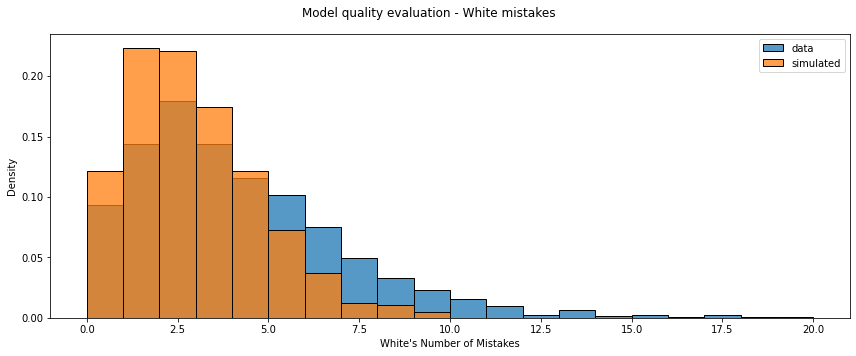

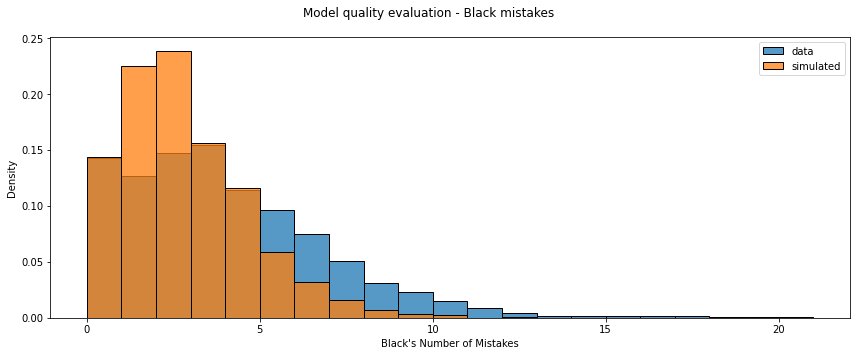

In [109]:
for color in ['White', 'Black']:
    fig, ax = plt.subplots(figsize=(12,5))
    fig.suptitle(f"Model quality evaluation - {color} mistakes")
    sns.histplot(data=df, x=f"{color}'s Number of Mistakes", binwidth=1, stat="density", ax=ax, label='data')
    sns.histplot(data=df_model_1_fit_transposed, x=f"mistakes_{color.lower()}_pred", binwidth=1, stat="density", ax=ax, label='simulated')
    plt.legend()
    plt.tight_layout()
    plt.plot()
    plt.show()

Posterior predictive samples are more or less consistent with the data. This is the result of the first (simpler) model, so we expect these results to improve in the second (more complex) model. Nevertheless, the results returned by the model considering only time control and rating difference are very satisfactory. Below we calculated overlap of posterior predictive samples and data.

In [110]:
def calculate_hist_overlap(df_data, df_fit):
    for color in ['White', 'Black']:
        overlap_coefficient = 0
        hist_data = []
        hist_fit = []
        for n in range(int(max(df_data[f"{color}'s Number of Mistakes"].max(), df_fit[f"mistakes_{color.lower()}_pred"].max()))):
            bar_data = np.count_nonzero(np.array(df_data[f"{color}'s Number of Mistakes"]) == n)
            bar_fit = np.count_nonzero(np.array(df_fit[f"mistakes_{color.lower()}_pred"]) == n)
            hist_data.append(bar_data)
            hist_fit.append(bar_fit)

        overlap_coefficient = np.minimum(hist_data, hist_fit).sum() / np.maximum(hist_data, hist_fit).sum()

        print(f"Overlap of posterior predictive samples and data for mistakes {color.lower()} :\t{np.round(100 * overlap_coefficient, 2)}%")

calculate_hist_overlap(df, df_model_1_fit_transposed)

Overlap of posterior predictive samples and data for mistakes white :	68.66%
Overlap of posterior predictive samples and data for mistakes black :	67.48%


#### d) Analysis of parameter marginal disrtibutions

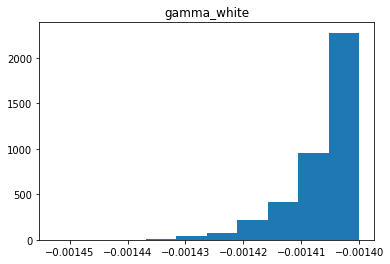

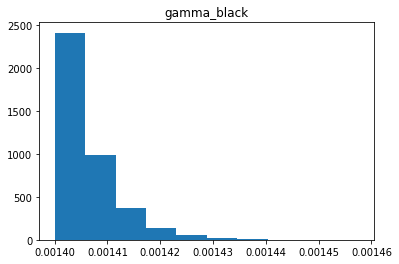

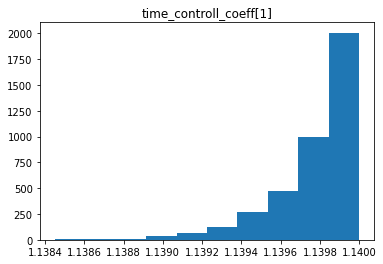

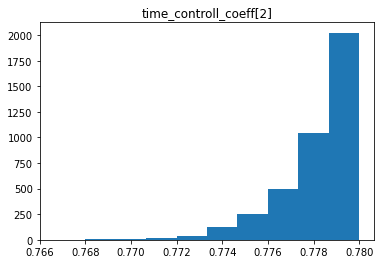

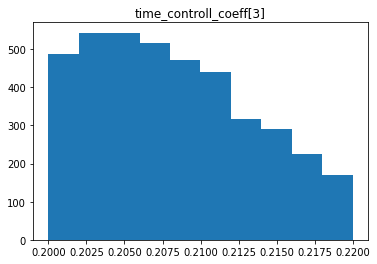

In [111]:
for parameter in ['gamma_white', 'gamma_black', 'time_controll_coeff[1]', 'time_controll_coeff[2]', 'time_controll_coeff[3]']:
    plt.hist(model_1_fit_df[parameter])
    plt.title(parameter)
    plt.show()

Comment: The parameter values are concentrated and quite close to those obtained by prior analysis.

## 6. Posterior analysis (Model 2)

Parameters chosen in prior

In [112]:
prior_parameters_model_2

{'gamma_white': -0.00141787,
 'gamma_black': 0.00154708,
 'time_controll_coeff[1]': 1.28198,
 'time_controll_coeff[2]': 0.840261,
 'time_controll_coeff[3]': 0.269627,
 'opening_coeff[1]': 0.675352,
 'opening_coeff[2]': 0.305338,
 'opening_coeff[3]': 0.389296,
 'opening_coeff[4]': 0.288916}

#### a) Model trainning and sampling

In [138]:
mistakes_white_model = deepcopy(mistakes_white_list)
mistakes_black_model = deepcopy(mistakes_black_list)

model_2_posterior = CmdStanModel(stan_file='stan_files/model_2_fit.stan')

model_2_fit = model_2_posterior.sample(
    data={
        'rating_difference': rating_difference_list,
        'N': len(time_control_list),
        'time_control': time_control_list,
        'mistakes_white_model': mistakes_white_model,
        'mistakes_black_model': mistakes_black_model,
        'opening': opening_list
        }
)

INFO:cmdstanpy:compiling stan file /home/projekt/stan_files/model_2_fit.stan to exe file /home/projekt/stan_files/model_2_fit
INFO:cmdstanpy:compiled model executable: /home/projekt/stan_files/model_2_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/projekt/stan_files/model_2_fit.hpp /home/projekt/stan_files/model_2_fit.stan
Warning in '/home/projekt/stan_files/model_2_fit.stan', line 2, column 12: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/home/projekt/stan_files/model_2_fit.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/projekt/stan_files/model_2_fit.stan', lin


INFO:cmdstanpy:CmdStan done processing.


There were no issues with the sampling.

#### b) Analysis of samples obtained from the predictive distribution.
Model summary:

In [114]:
summary = model_2_fit.summary()
summary.head(10)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,5300.0000,7.400000e-02,2.500000,5300.0000,5300.0000,5300.0000,1100.0,23.0,1.0
gamma_white,-0.0013,5.100000e-08,0.000004,-0.0013,-0.0013,-0.0013,5600.0,110.0,1.0
gamma_black,0.0013,7.000000e-08,0.000005,0.0013,0.0013,0.0013,5200.0,110.0,1.0
time_controll_coeff_blitz,1.3000,3.600000e-05,0.002600,1.3000,1.3000,1.3000,5300.0,110.0,1.0
time_controll_coeff_rapid,0.4800,4.100000e-06,0.000310,0.4800,0.4800,0.4800,5700.0,120.0,1.0
time_controll_coeff_classic,0.3500,6.200000e-06,0.000440,0.3500,0.3500,0.3500,5100.0,100.0,1.0
opening_coeff_sicilian,0.5700,2.600000e-05,0.001900,0.5700,0.5700,0.5800,5800.0,120.0,1.0
opening_coeff_petroff,0.3600,7.400000e-05,0.005500,0.3500,0.3600,0.3700,5500.0,110.0,1.0
opening_coeff_queen_pawn,0.3400,2.000000e-05,0.001500,0.3300,0.3400,0.3400,5700.0,120.0,1.0


Parameters values are similiar to those from priors but not the same.

In [115]:
model_2_fit_df = model_2_fit.draws_pd()
model_2_fit_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,gamma_white,gamma_black,time_controll_coeff_blitz,...,mistakes_black_pred[2018],mistakes_black_pred[2019],mistakes_black_pred[2020],mistakes_black_pred[2021],mistakes_black_pred[2022],mistakes_black_pred[2023],mistakes_black_pred[2024],mistakes_black_pred[2025],mistakes_black_pred[2026],mistakes_black_pred[2027]
0,5292.56,0.876941,0.455339,3.0,7.0,0.0,-5288.18,-0.001301,0.001302,1.26627,...,1.0,1.0,8.0,3.0,1.0,5.0,3.0,1.0,1.0,1.0
1,5290.63,0.804896,0.455339,3.0,7.0,0.0,-5285.84,-0.001313,0.001311,1.26986,...,3.0,1.0,7.0,2.0,3.0,6.0,0.0,4.0,1.0,3.0
2,5288.97,0.884348,0.455339,3.0,7.0,0.0,-5287.30,-0.001300,0.001301,1.26060,...,2.0,0.0,5.0,3.0,8.0,8.0,3.0,7.0,1.0,6.0
3,5284.28,0.941027,0.455339,3.0,7.0,0.0,-5280.57,-0.001302,0.001300,1.26007,...,2.0,1.0,7.0,4.0,8.0,6.0,2.0,8.0,2.0,3.0
4,5290.04,0.997787,0.455339,3.0,7.0,0.0,-5281.52,-0.001302,0.001300,1.26841,...,4.0,2.0,7.0,3.0,3.0,6.0,2.0,5.0,3.0,8.0


Choosing sample with best matching to reality.

In [116]:
best_matching = -1
best_matching_ind = -1

for row_index, row in model_2_fit_df.iterrows():
    tmp_mistakes_white = []
    tmp_mistakes_black = []

    for i in range(N):
        tmp_mistakes_white.append(row[f'mistakes_white_pred[{i+1}]'])
        tmp_mistakes_black.append(row[f'mistakes_black_pred[{i+1}]'])

    number_of_matched_white = sum(1 for x, y in zip(tmp_mistakes_white, mistakes_white_list) if x == y)
    number_of_matched_black = sum(1 for x, y in zip(tmp_mistakes_black, mistakes_black_list) if x == y)
    acceptance_percent = ((number_of_matched_white + number_of_matched_black) / (len(mistakes_white_list) + len(mistakes_black_list))) * 100

    if acceptance_percent > best_matching:
        best_matching = acceptance_percent
        best_matching_ind = row_index

chosen_row_in_posterior_model_2 = best_matching_ind

Creating pandas DataFrame with chosen posterior predictive samples

In [117]:
mistakes_white_pred = []
mistakes_black_pred = []

for i in range(N):
    mistakes_white_pred.append(model_2_fit_df[f'mistakes_white_pred[{i+1}]'].values[chosen_row_in_posterior_model_2])
    mistakes_black_pred.append(model_2_fit_df[f'mistakes_black_pred[{i+1}]'].values[chosen_row_in_posterior_model_2])

df_model_2_fit_transposed = pd.DataFrame({'mistakes_white_pred': mistakes_white_pred, 'mistakes_black_pred': mistakes_black_pred})
df_model_2_fit_transposed

,mistakes_white_pred,mistakes_black_pred
0,5.0,2.0
1,6.0,4.0
2,2.0,2.0
3,2.0,2.0
4,3.0,3.0
...,...,...
2022,7.0,8.0
2023,2.0,5.0
2024,2.0,4.0
2025,2.0,3.0


#### c) Analysis of posterior predictive samples

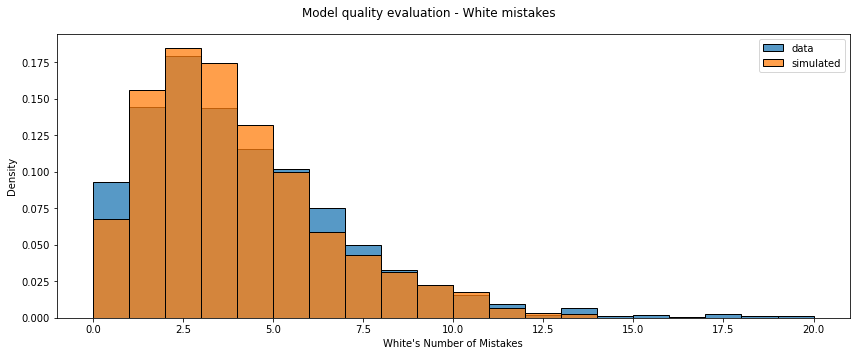

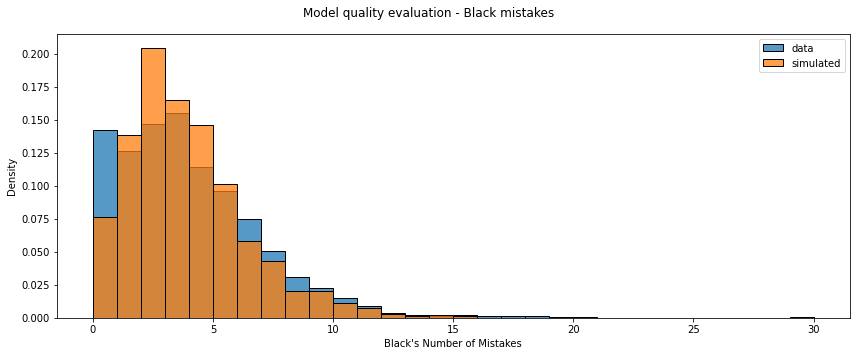

In [118]:
for color in ['White', 'Black']:
    fig, ax = plt.subplots(figsize=(12,5))
    fig.suptitle(f"Model quality evaluation - {color} mistakes")
    sns.histplot(data=df, x=f"{color}'s Number of Mistakes", binwidth=1, stat="density", ax=ax, label='data')
    sns.histplot(data=df_model_2_fit_transposed, x=f"mistakes_{color.lower()}_pred", binwidth=1, stat="density", ax=ax, label='simulated')
    plt.legend()
    plt.tight_layout()
    plt.plot()
    plt.show()

Posterior predictive samples are consistent with the data. This is the result of the second (more complex) model and (as we xpected) it is better than result from first (simpler) model. The results returned by the model considering time control, rating difference and chosen opening are very satisfactory. Below we calculated overlap of posterior predictive samples and data.

In [119]:
calculate_hist_overlap(df, df_model_2_fit_transposed)

Overlap of posterior predictive samples and data for mistakes white :	87.29%
Overlap of posterior predictive samples and data for mistakes black :	79.02%


#### d) Analysis of parameter marginal disrtibutions

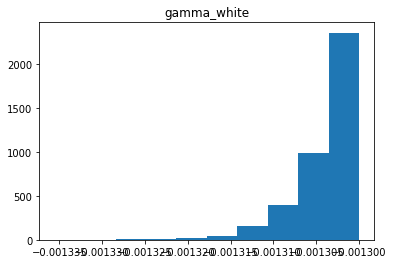

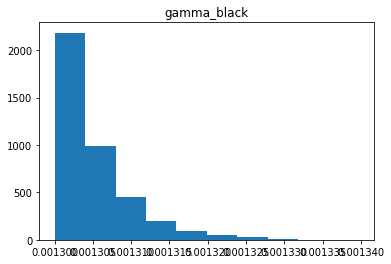

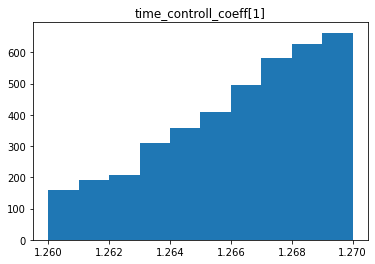

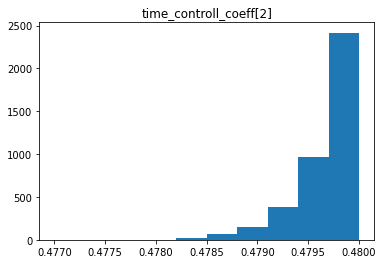

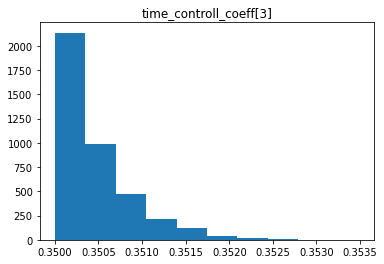

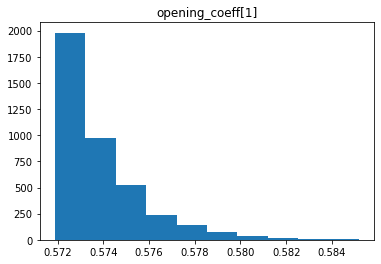

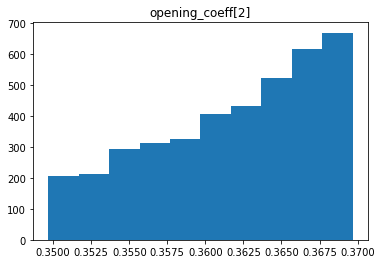

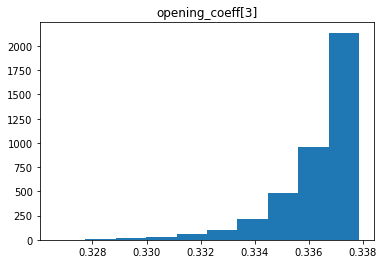

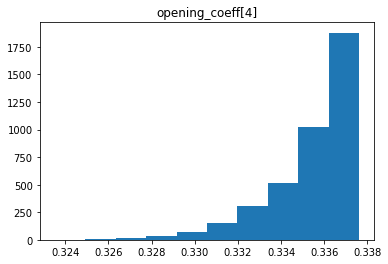

In [121]:
for parameter in ['gamma_white', 'gamma_black', 'time_controll_coeff[1]', 'time_controll_coeff[2]', 'time_controll_coeff[3]', 
                 'opening_coeff[1]', 'opening_coeff[2]', 'opening_coeff[3]', 'opening_coeff[4]']:
    plt.hist(model_2_fit_df[parameter])
    plt.title(parameter)
    plt.show()

Comment: The parameter values are concentrated and quite close to those obtained by prior analysis.

## 7. Model comaprison

#### a) Comparison using information criteria

WAIC


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Model 2,0,-4252.434847,0.129815,0.000000,0.974588,54.040376,0.000000,False,log
Model 1,1,-4968.331503,0.044622,715.896655,0.025412,95.905208,51.299359,False,log


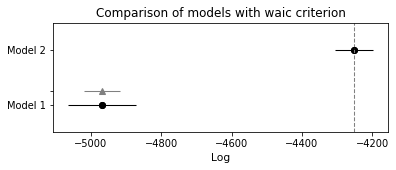





LOO


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Model 2,0,-4252.434849,0.129816,0.000000,0.974588,54.040376,0.00000,False,log
Model 1,1,-4968.331510,0.044628,715.896661,0.025412,95.905209,51.29936,True,log


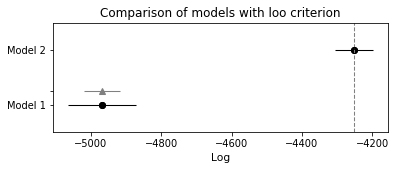

In [168]:
compare_dict = {
    "Model 1": az.from_cmdstanpy(posterior=model_1_fit), 
    "Model 2": az.from_cmdstanpy(posterior=model_2_fit)
    }

for information_criteria in ["waic", "loo"]:
    diff = az.compare(compare_dict=compare_dict, ic=information_criteria)
    print(f"{information_criteria.upper()}")
    print("="*100)
    display(diff)
    ax = az.plot_compare(diff)
    ax.set_title(f"Comparison of models with {information_criteria} criterion")
    plt.show()
    print("="*100)
    if information_criteria == "waic":
        print('\n\n\n')

#### b) Conclusions and comments drawn from the result for WAIC 

The results obtained for the Watanabe-Akaike Information Criterio (WAIC) ratio allow comparing the "Model 1" and "Model 2" models on the basis of predictive evaluation.
- Model 2 has a "rank" of 0, indicating that it is better than Model 1, which has a rank of 1.
- "waic" refers to the Watanabe-Akaike Information Criterion (WAIC) value for each model. Model 2 has a WAIC value of -4252.434847, while Model 1 has a WAIC value of -4968.331503.
- "p_waic" represents the estimated value of the WAIC estimate along with the standard error. For Model 2, it is 0.129815, and for Model 1, it is 0.044622.
- "d_waic" shows the difference in WAIC between Model 2 and Model 1. In this case, it is 715.896655, indicating that Model 2 has a lower WAIC by that amount compared to Model 1.
- "weight" represents the weight assigned to each model based on WAIC comparisons. For Model 2, the weight is 0.974588, and for Model 1, it is 0.025412. A higher weight implies a higher probability that the model is well-fitted to the data.
- "se" indicates the standard error for the model weights. For Model 2, it is 54.040376, and for Model 1, it is 95.905208.
- "dse" represents the standard error for the difference in WAIC between the models. For Model 2, it is 0.000000, and for Model 1, it is 51.299359.
- "warning" indicates whether any warnings occurred during the calculations. Both models have a value of False, suggesting that no warnings were raised.
- "waic_scale" specifies the scale used for WAIC calculation. In this case, it is "log" for both models.

In summary, based on the results from the az.compare function, it can be concluded that Model 2 has a lower WAIC, lower standard error, higher weight, and no warnings compared to Model 1. This suggests that Model 2 is better fitted to the data and more reliable according to the Watanabe-Akaike Information Criterion.

#### c) Conclusions and comments drawn from the result for LOO

The results obtained for the Leave-One-Out (LOO) ratio allow comparing the "Model 1" and "Model 2" models on the basis of predictive evaluation.
- Model 2 has a "rank" of 0, which means it is better than Model 1, which has a rank of 1.
- "loo" refers to the Leave-One-Out (LOO) value for each model. Model 2 has a LOO value of -4252.434849, while Model 1 has a LOO value of -4968.331510.
- "p_loo" represents the estimated value of the LOO estimate along with the standard error. For Model 2, it is 0.129816, and for Model 1, it is 0.044628.
- "d_loo" shows the difference in LOO between Model 2 and Model 1. In this case, it is 715.896661, indicating that Model 2 has a lower LOO by that amount compared to Model 1.
- "weight" represents the weight assigned to each model based on LOO comparisons. For Model 2, the weight is 0.974588, and for Model 1, it is 0.025412. A higher weight implies a higher probability that the model is well-fitted to the data.
- "se" indicates the standard error for the model weights. For Model 2, it is 54.040376, and for Model 1, it is 95.905209.
- "dse" represents the standard error for the difference in LOO between the models. For Model 2, it is 0.00000, and for Model 1, it is 51.29936.
- "warning" indicates whether any warnings occurred during the calculations. For Model 2, the value is False, and for Model 1, it is True.
- "loo_scale" specifies the scale used for LOO estimation. In this case, it is "log" for both models.

In summary - Model 2 has a lower LOO, lower standard error, higher weight, and no warning compared to Model 1. This suggests that Model 2 is better fitted to the data and more reliable.

#### d) Final conclusions

The comparison made above using information criteria confirmed our earlier conclusions. Model 2 proved to be significantly better, showing that the impact of chess opening selection on the course of the game is significant. As chess players, we predicted that we would get such results after comparing these models.